In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31") #"GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"

[*********************100%***********************]  6 of 6 completed


In [3]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2010-01-04  6.505280  24.106218  19.280519  32.229893  15.610239  39.131073   
2010-01-05  6.516528  23.740725  19.436932  32.749939  15.541497  38.881397   
2010-01-06  6.412874  23.891224  19.737720  32.407478  15.149715  38.807621   
2010-01-07  6.401019  23.732660  19.912172  32.553337  14.797037  38.643066   
2010-01-08  6.443574  23.660105  19.644474  33.739288  14.994298  38.586315   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   
2010-01-08  7.570714  44.020000  32.654999  41.323200  ...  33.334999   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   
2010-01-08  40.740635  14.744733  68.133118  447610800.0  3307737.0   

                                                           
               BMW.DE      DBK.DE         GOOG     RWE.DE  
Date                                                       
2010-01-04  1808170.0   4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0   5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0   5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0   4506202.0  257533695.0  1765257.0  
2010-01-08  1925894.0  10753806.0  189680313.0  1665122.0  

[5 rows x 36 columns]

In [4]:
data = data["Adj Close"]

In [5]:
data = pd.DataFrame(np.diff(np.log(data[1:]), axis=0), columns=data.columns)

In [6]:
data = data.dropna(axis=0)

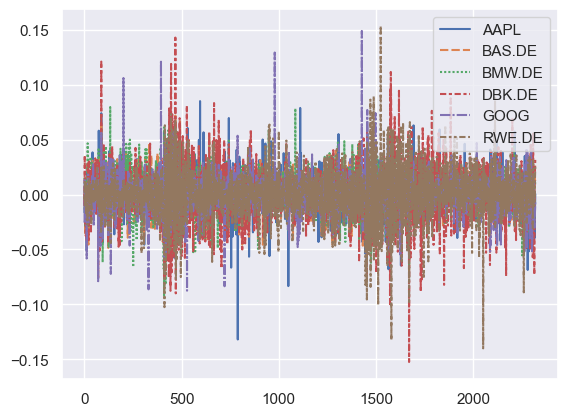

In [7]:
sns.lineplot(data = data);

In [8]:
np.mean(data.iloc[0])

-0.0053835523827689595

In [9]:
data.iloc[0]

AAPL     -0.016034
BAS.DE    0.006319
BMW.DE    0.015357
DBK.DE   -0.010512
GOOG     -0.025532
RWE.DE   -0.001899
Name: 0, dtype: float64

In [10]:
PF = data.mean(axis=1)

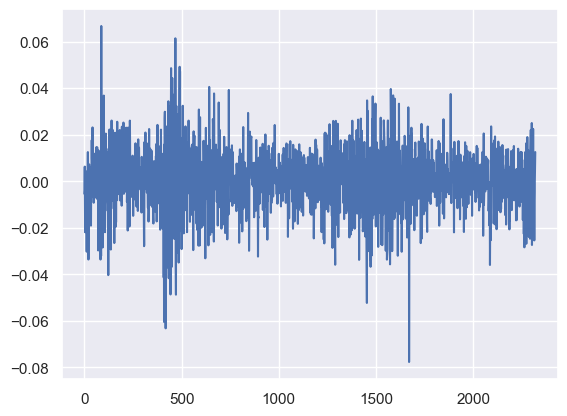

In [11]:
sns.lineplot(x = PF.index, y = PF);

# ARMA-GARCH

In [12]:
from arch import arch_model

In [13]:
am = arch_model(data.AAPL*100, vol="Garch", p=1, o=0, q=1, dist="skewt")

In [14]:
res = am.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 61935.077983843315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 134546.11992867957
Iteration:      3,   Func. Count:     27,   Neg. LLF: 80272.43956021735
Iteration:      4,   Func. Count:     36,   Neg. LLF: 109181.22267121432
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.816311700843
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.196161878653
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5193.811342402383
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.979889701022
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.372131715998
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.160802844839
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.148449163922
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.148292241871
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1482905285884
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851.1

In [15]:
res.resid

0      -1.704851
1      -0.286484
2       0.561187
3      -0.987518
4      -1.245451
          ...   
2312    1.189455
2313   -3.270290
2314   -2.657302
2315   -4.068681
2319   -0.050227
Name: resid, Length: 2134, dtype: float64

In [40]:
res.params

mu          0.101441
omega       0.150625
alpha[1]    0.115298
beta[1]     0.838461
eta         4.398346
lambda     -0.033146
Name: params, dtype: float64

In [16]:
def get_residuals(returns):
    am = arch_model(100*returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
    res = am.fit()

    return res.resid


In [17]:
garch_results = pd.DataFrame()

for i in range(0,data.shape[1]):
    print(i)
    garch_results[data.columns[i]] = get_residuals(data.iloc[:,i])
    

0
Iteration:      1,   Func. Count:      8,   Neg. LLF: 61935.077983843315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 134546.11992867957
Iteration:      3,   Func. Count:     27,   Neg. LLF: 80272.43956021735
Iteration:      4,   Func. Count:     36,   Neg. LLF: 109181.22267121432
Iteration:      5,   Func. Count:     45,   Neg. LLF: 5525.816311700843
Iteration:      6,   Func. Count:     53,   Neg. LLF: 3863.196161878653
Iteration:      7,   Func. Count:     61,   Neg. LLF: 5193.811342402383
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3858.979889701022
Iteration:      9,   Func. Count:     77,   Neg. LLF: 3851.372131715998
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3851.160802844839
Iteration:     11,   Func. Count:     93,   Neg. LLF: 3851.148449163922
Iteration:     12,   Func. Count:    100,   Neg. LLF: 3851.148292241871
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3851.1482905285884
Iteration:     14,   Func. Count:    113,   Neg. LLF: 3851

In [18]:
garch_results

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,-1.704851,0.586341,1.498647,-0.987272,-2.610575,-0.150218
1,-0.286484,-0.711489,0.842954,0.512985,-2.412860,-0.385219
2,0.561187,-0.351775,-1.390527,3.642227,1.266921,-0.107259
3,-0.987518,-1.164962,-1.533381,-1.146401,-0.208653,1.209313
4,-1.245451,-3.671295,-2.986508,-2.557640,-1.841603,-0.982927
...,...,...,...,...,...,...
2312,1.189455,0.325085,-0.755792,-0.145173,1.133693,-1.051507
2313,-3.270290,1.423555,-0.064252,-1.438676,-0.613014,0.975742
2314,-2.657302,-1.028189,-2.253358,-7.234579,-1.395708,-0.817979
2315,-4.068681,1.564814,0.088196,0.662120,-3.061202,-0.274041


In [25]:
# fit copula

In [65]:
u = am.distribution.cdf(garch_results, parameters=[res.params["eta"], res.params["lambda"]])

In [66]:
cop = pv.Vinecop(u)

In [71]:
sim = cop.simulate(100)

In [74]:
sim.shape

(100, 6)

In [75]:
new_res = am.distribution.ppf(sim, parameters=[res.params["eta"], res.params["lambda"]])

In [77]:
new_res.shape

(100, 6)

In [91]:
import numpy as np

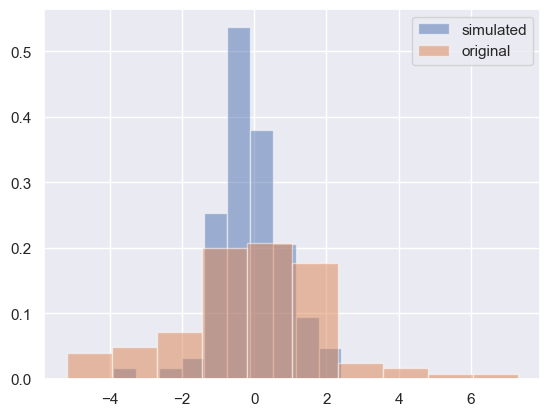

In [96]:
bins = np.linspace(-10, 10, 100)
plt.hist(new_res[:,0], alpha=0.5, label='simulated', density=True)
plt.hist(garch_results.iloc[0:100,0], alpha=0.5, label='original', density=True)
plt.legend(loc='upper right')
plt.show()

In [88]:
new_res[:,0].size

100

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.500e+01, 1.170e+02, 7.590e+02,
        1.077e+03, 1.390e+02, 1.900e+01, 4.000e+00]),
 array([-13.28987718, -11.12081292,  -8.95174866,  -6.7826844 ,
         -4.61362014,  -2.44455588,  -0.27549162,   1.89357264,
          4.06263691,   6.23170117,   8.40076543]),
 <BarContainer object of 10 artists>)

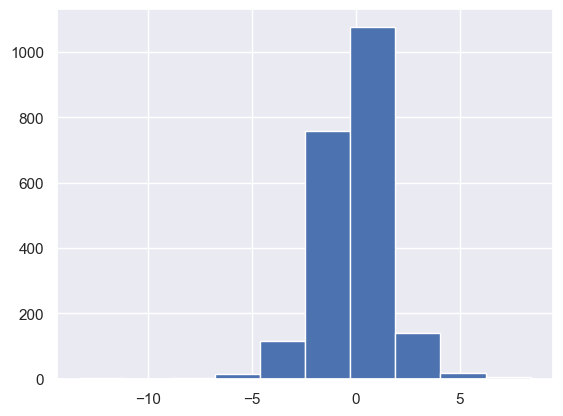

In [84]:
plt.hist(garch_results.iloc[:,0])

In [83]:
garch_results[:,0]

InvalidIndexError: (slice(None, None, None), 0)

In [62]:
q = am.distribution.cdf(garch_results.iloc[:,0], parameters=[res.params["eta"], res.params["lambda"]])

In [54]:
import matplotlib.pyplot as plt

(array([1.000e+00, 0.000e+00, 3.000e+00, 1.500e+01, 1.170e+02, 7.590e+02,
        1.077e+03, 1.390e+02, 1.900e+01, 4.000e+00]),
 array([-13.28987718, -11.12081292,  -8.95174866,  -6.7826844 ,
         -4.61362014,  -2.44455588,  -0.27549162,   1.89357264,
          4.06263691,   6.23170117,   8.40076543]),
 <BarContainer object of 10 artists>)

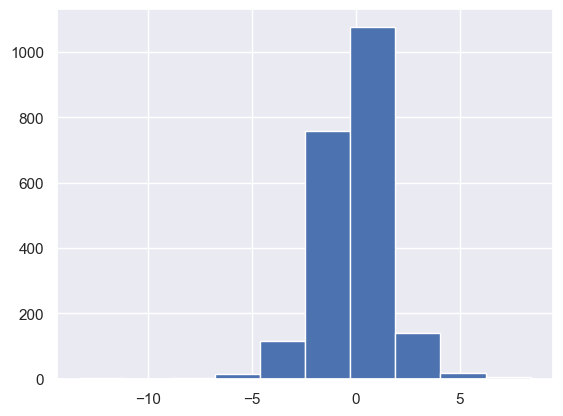

In [59]:
plt.hist(garch_results.iloc[:,0])

In [69]:
u[:,0]

array([0.03982838, 0.35221148, 0.75431214, ..., 0.01051957, 0.00223517,
       0.46668172])

(array([404., 205., 186., 166., 138., 136., 119., 167., 194., 419.]),
 array([1.60607243e-05, 1.00005939e-01, 1.99995817e-01, 2.99985695e-01,
        3.99975574e-01, 4.99965452e-01, 5.99955330e-01, 6.99945208e-01,
        7.99935087e-01, 8.99924965e-01, 9.99914843e-01]),
 <BarContainer object of 10 artists>)

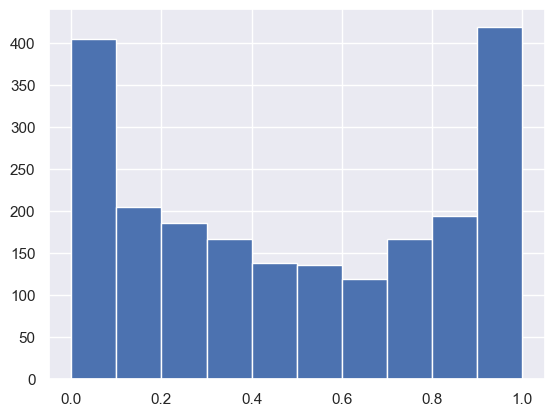

In [70]:
plt.hist(u[:,0])

# Copula VaR

In [19]:
u = pv.to_pseudo_obs(data)

In [20]:
cop = pv.Vinecop(u)

In [21]:
cop.aic()

-4671.504980797427

In [22]:
cop.families

[[<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.student: 2>,
  <BicopFamily.student: 2>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>,
  <BicopFamily.tll: 11>],
 [<BicopFamily.tll: 11>, <BicopFamily.bb8: 10>, <BicopFamily.frank: 5>],
 [<BicopFamily.tll: 11>, <BicopFamily.tll: 11>],
 [<BicopFamily.joe: 6>]]

In [23]:
cop.structure

<pyvinecopulib.RVineStructure>
5 2 2 2 6 6 
2 4 4 6 2 
4 3 6 4 
3 6 3 
6 5 
1 

In [24]:
cop.simulate(100)

array([[0.70590085, 0.91635232, 0.79233755, 0.25962911, 0.11004199,
        0.49971536],
       [0.55078693, 0.77716786, 0.10854197, 0.9193415 , 0.27094815,
        0.9147691 ],
       [0.95002445, 0.98460608, 0.95863757, 0.91454945, 0.89596877,
        0.88821579],
       [0.62881916, 0.83888238, 0.8704798 , 0.87734805, 0.93095078,
        0.69166315],
       [0.88367507, 0.55191066, 0.40731545, 0.23337414, 0.47389228,
        0.95218373],
       [0.24291048, 0.01168178, 0.00535425, 0.01481295, 0.04378578,
        0.04892399],
       [0.22105764, 0.61442313, 0.84154417, 0.67159902, 0.36033617,
        0.12541943],
       [0.96955313, 0.43274171, 0.95457291, 0.84029643, 0.9013945 ,
        0.69623825],
       [0.11846441, 0.02766465, 0.25783091, 0.16040748, 0.37256399,
        0.06844072],
       [0.8520327 , 0.48079444, 0.22664521, 0.85706014, 0.94403932,
        0.04733985],
       [0.76771437, 0.35660364, 0.37351091, 0.28319785, 0.78840472,
        0.63817848],
       [0.07491526, 0